In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
# library imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import PIL 

In [ ]:
# data loading
image_dir = Path('/content/mydrive/MyDrive/Lumpy Skin Images Dataset')

# get filepaths and labels
filepaths1 = list(image_dir.glob(r'**/*.png'))
filepaths2 = list(image_dir.glob(r'**/*.jpg'))
filepaths = filepaths1 + filepaths2

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

# generating text file for annotations
unique_list = image_df['Label'].unique().tolist()
classes = len(unique_list)

with open('/content/mydrive/MyDrive/Lumpy Skin Images Dataset/annotations.txt', 'w') as filehandle:
    for listitem in unique_list:
        filehandle.write('%s\n' % listitem)

In [ ]:
# shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# show the result
image_df.head()

,Filepath,Label
0,/content/mydrive/MyDrive/Lumpy Skin Images Dat...,Lumpy Skin
1,/content/mydrive/MyDrive/Lumpy Skin Images Dat...,Normal Skin
2,/content/mydrive/MyDrive/Lumpy Skin Images Dat...,Normal Skin
3,/content/mydrive/MyDrive/Lumpy Skin Images Dat...,Normal Skin
4,/content/mydrive/MyDrive/Lumpy Skin Images Dat...,Normal Skin


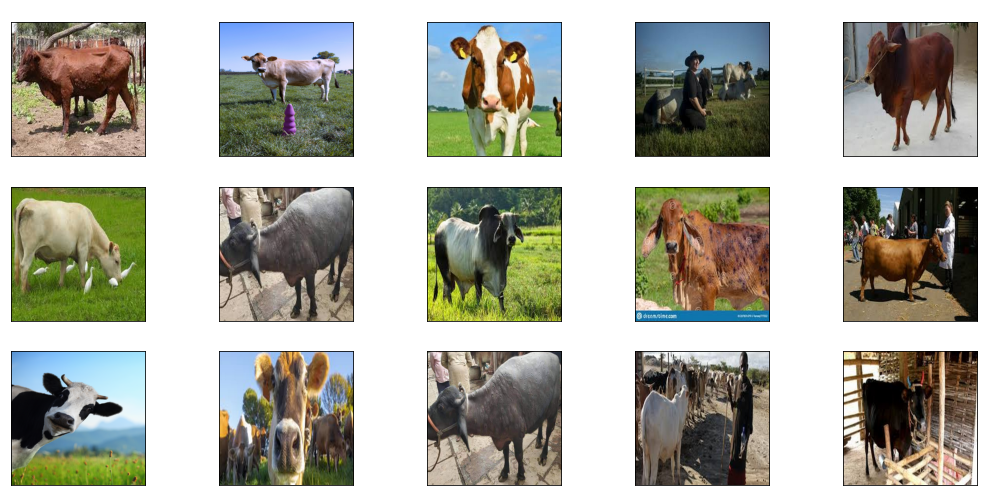

In [ ]:
# display 15 picture of the dataset with their labels
from turtle import color

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for b, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[b]))
    ax.set_title(image_df.Label[b], color='white')
plt.tight_layout()
plt.show()

In [ ]:
# separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,horizontal_flip=True, vertical_flip=True,rescale=1.255,fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,rescale=1.255
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 656 validated image filenames belonging to 2 classes.
Found 163 validated image filenames belonging to 2 classes.
Found 205 validated image filenames belonging to 2 classes.


In [ ]:
# loading the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max',
    classes=2
)

pretrained_model.trainable = False

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
# model architecture & training
inputs = pretrained_model.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=1,
    #         restore_best_weights=True
    #     )
    # ]
)

Epoch 1/20
21/21 [==============================] - 134s 6s/step - loss: 0.8455 - accuracy: 0.6646 - val_loss: 0.6321 - val_accuracy: 0.6994
Epoch 2/20
21/21 [==============================] - 117s 6s/step - loss: 0.5260 - accuracy: 0.7363 - val_loss: 0.5320 - val_accuracy: 0.7239
Epoch 3/20
21/21 [==============================] - 117s 6s/step - loss: 0.4085 - accuracy: 0.7973 - val_loss: 0.3830 - val_accuracy: 0.8466
Epoch 4/20
21/21 [==============================] - 113s 5s/step - loss: 0.3942 - accuracy: 0.8247 - val_loss: 0.4421 - val_accuracy: 0.8221
Epoch 5/20
21/21 [==============================] - 119s 6s/step - loss: 0.3219 - accuracy: 0.8628 - val_loss: 0.6058 - val_accuracy: 0.7607
Epoch 6/20
21/21 [==============================] - 110s 5s/step - loss: 0.3052 - accuracy: 0.8720 - val_loss: 0.4104 - val_accuracy: 0.8405
Epoch 7/20
21/21 [==============================] - 116s 6s/step - loss: 0.2546 - accuracy: 0.8857 - val_loss: 0.4377 - val_accuracy: 0.8221
Epoch 8/20
21

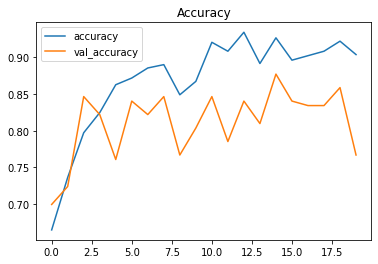

In [ ]:
# accuracy visualization
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

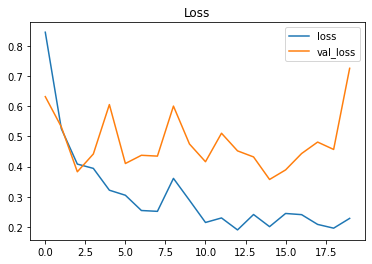

In [ ]:
# loss visualization
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
model.save('/content/mydrive/MyDrive/results/EffecientNet')